In [1]:
import logging
import numpy as np

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

from opt_funcs_nsls import make_dummy_eval

logger = logging.getLogger(__name__)

SETUP SINGLE-OBJECTIVE RUN (i.e. only lifetime)

In [2]:
variables = {'x0':[0,1], # magnet current/knob/etc.
              'x1':[0,1]}
objectives = {'LT':'maximize', 'EFF':'maximize'}
objectives_active = {'LT':'maximize'}
reference_point = {'LT':0.7, # hours
                   'EFF':0.5 # fraction injected
                   }
initial_variable_values = {'x0':0.1, 'x1':0.1}

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives,
              objectives_active=objectives_active)

In [3]:
eval_f = make_dummy_eval(gvocs)
ev = FunctionEvaluator(script=eval_f)

generator_name = 'bo_ucb'
gc = get_generator_class(generator_name)

gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 512
gen.numerical_optimizer.n_restarts = 10
gen.gp_constructor.use_low_noise_prior = False

In [4]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

Sample at initial values (i.e. standard lattice)

In [5]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

In [6]:
opt.data

,x0,x1,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF
1,0.1,0.1,"{'LT': 8.91732521861159, 'EFF': 0.172410838209...",None,,0.000088,0.0,True,8.917325,0.172411


Sample close to initial point

In [7]:
mt = {'x0':0.05, 'x1':0.05}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

In [8]:
opt.data

,x0,x1,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF
1,0.10000,0.100000,"{'LT': 8.91732521861159, 'EFF': 0.172410838209...",None,,0.000088,0.0,True,8.917325,0.172411
2,0.11402,0.093631,"{'LT': 9.349294904278974, 'EFF': 0.21657069402...",None,,0.000055,0.0,True,9.349295,0.216571


Run optimizer

In [9]:
import warnings
#warnings.filterwarnings("ignore", message="Unable to find non-zero acquisition function values")

for i in range(50):
    opt.step()

In [11]:
opt.data.tail()

,x0,x1,result,exception,traceback,wall_time,cpu_time,valid,LT,EFF
48,0.382511,0.529018,"{'LT': 9.987568843565633, 'EFF': 0.98093747608...",None,,0.000046,0.0,True,9.987569,0.980937
49,0.381185,0.530845,"{'LT': 9.893508813060816, 'EFF': 0.93299170600...",None,,0.000048,0.0,True,9.893509,0.932992
50,0.382638,0.527764,"{'LT': 10.104021212519745, 'EFF': 0.8401508892...",None,,0.000048,0.0,True,10.104021,0.840151
51,0.377847,0.533147,"{'LT': 9.62596113907777, 'EFF': 0.810700673337...",None,,0.000056,0.0,True,9.625961,0.810701
52,0.392178,0.503849,"{'LT': 9.750092645314329, 'EFF': 0.82971991578...",None,,0.000056,0.0,True,9.750093,0.829720


Text(0, 0.5, 'Objective')

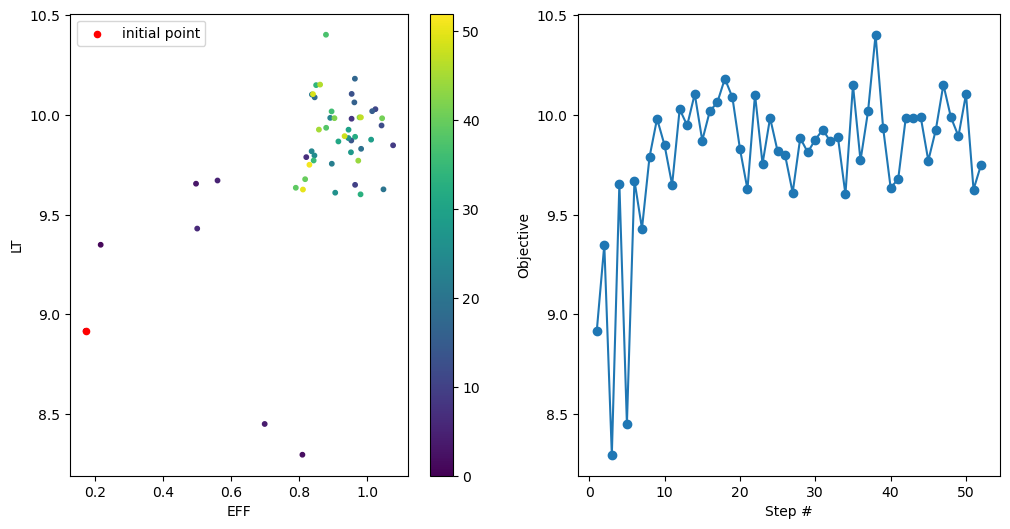

In [12]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(df.loc[:,gvocs.objective_names_active[0]],marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Objective')

In [15]:
# This will save optimizer state
opt.state_to_json('sobo_dump.json')

import os
os.remove('sobo_dump.json')